# Урок 3
Этот ноутбук будет разбит на две части для удобства демонстрации.

Это часть 1/2: про Dropout и Batch Normalization.

## План
В этой практической работе мы узнаем новые трюки и попробуем через эксперименты посмотреть, насколько эти трюки хороши.

**В первом ноутбуке** мы познакомимся с Dropout и Batch Normalization слоями.

**Во втором ноутбуке** мы вернемся к модели классификации изображений из прошлого урока и попробуем ее улучшать.

## Знакомимся с Dropout и Batch Normalization

### Dropout
Напомним, что Dropout берет входной тензор и зануляет каждый элемент с вероятностью $p$.
Эта вероятность $p$ - гиперпараметр.
Она задается заранее и не обучается на данных.

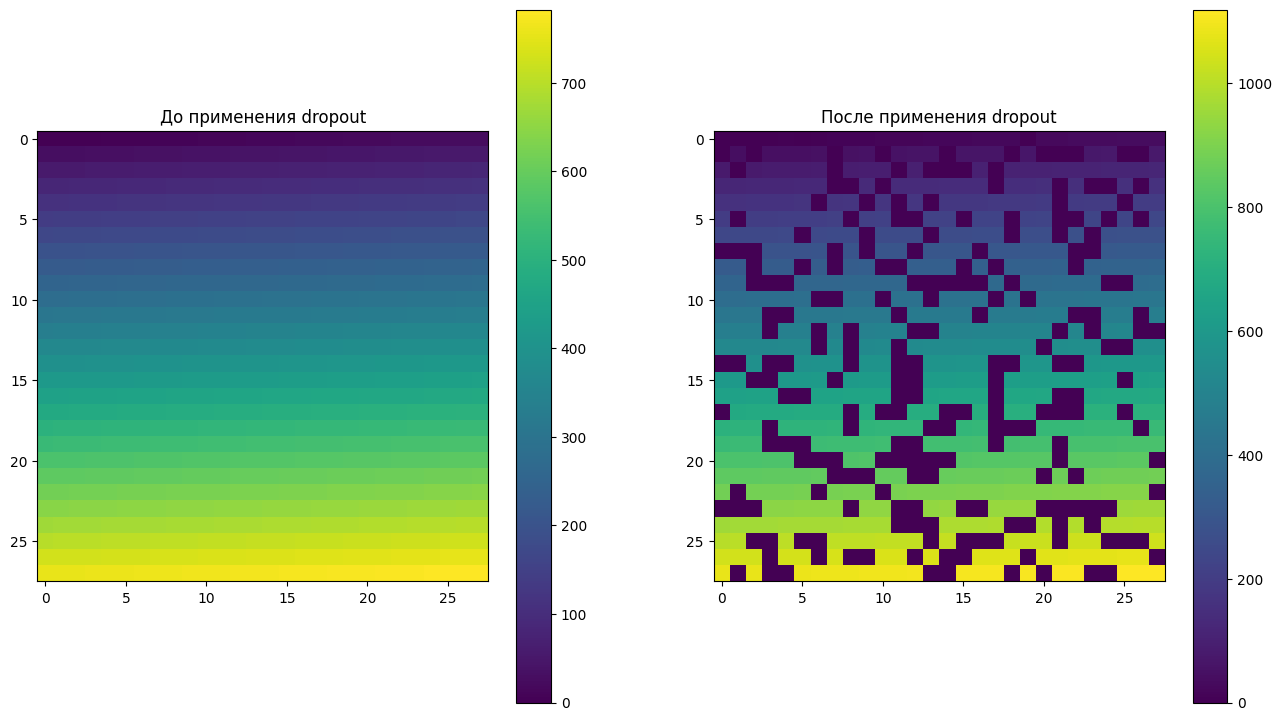

In [1]:
# большинство слоев лежит в torch.nn - обычно его импортируют как nn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dropout_layer = nn.Dropout(p=0.3)
tensor = torch.arange(28 * 28, dtype=float).reshape((28, 28))

fig, ax = plt.subplots(1, 2, figsize=(16, 9))
plt.colorbar(ax[0].imshow(tensor.numpy()), ax=ax[0])
ax[0].set_title("До применения dropout")

tensor_after_dropout = dropout_layer(tensor)
plt.colorbar(ax[1].imshow(tensor_after_dropout.numpy()), ax=ax[1])
ax[1].set_title("После применения dropout");

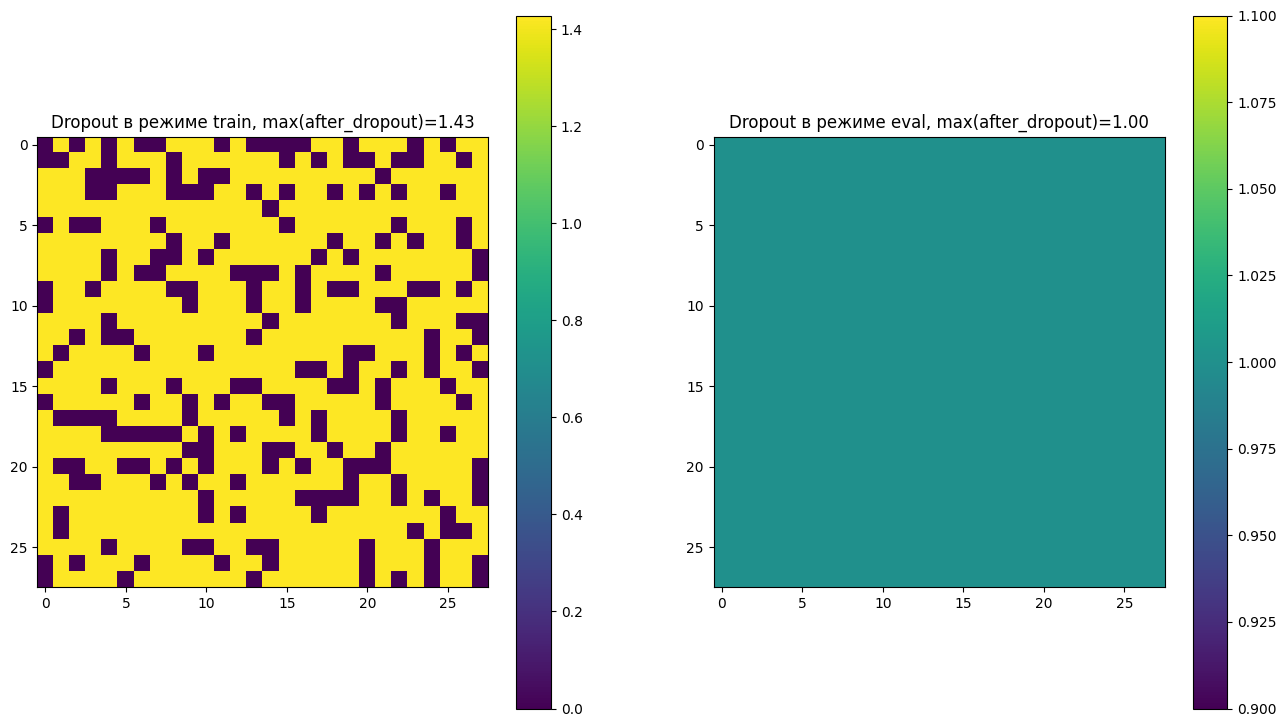

In [2]:
# В режиме train dropout нормирует на 1 / (1 - p)
dropout_layer.train()
ones = torch.ones((28, 28))
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
after_dropout = dropout_layer(ones)

plt.colorbar(ax[0].imshow(after_dropout.numpy()), ax=ax[0])
# В режиме train Dropout незануленные значения увеличивает в 1.42 = 1 / (1 - 0.3) раза
ax[0].set_title(
    f"Dropout в режиме train, max(after_dropout)={torch.max(after_dropout):.2f}"
)

# В режиме eval слой dropout просто пропускает сигнал (как будто слоя нет вовсе)
# Переведем в inference-режим (он же eval режим)
dropout_layer.eval()
# еще можно так:
# dropout_layer.train(False)

# И увидим, что теперь не умножается на 1.42
after_dropout = dropout_layer(ones)
plt.colorbar(ax[1].imshow(dropout_layer(ones).numpy()), ax=ax[1])
# А в режиме eval Dropout не изменяет сигнал
ax[1].set_title(
    f"Dropout в режиме eval, max(after_dropout)={torch.max(after_dropout):.2f}"
);

### Batch Noramalization
Напомним, как работает Batch Normalization.

В режиме **train** этот слой считает среднее $\mu_B$ и дисперсию $\sigma_B^2$ (смещенная оценка) на каждом батче.
Затем из батча вычитает среднее и делит на дисперсию.
На выход выдается $y = \gamma \bar{x} + \beta$, где $\bar{x} = \frac{x - \mu_B}{\sqrt{\sigma_B^2 + \varepsilon}}$, а $\gamma$ и $\beta$ - обучаемые параметры, $\varepsilon$ - гиперпараметр, обычно это $10^{-5}$ (нужен, чтобы не было деления на ноль).

Помимо этого Batch Normalization считает скользящее среднее по всем батчам, которые через него прошли. Делается это так:
1. Берем $\mu = 0$, $\sigma = 0$.
2. Как только проходит новый батч, считаем среднее $\mu_B$ и дисперсию $\sigma_B^3$ по нему.
3. Обновляем $\mu \leftarrow \alpha \mu + (1 - \alpha) \mu_B$. Здесь $\alpha$ - гиперпараметр.
4. Обновляем $\sigma \leftarrow \alpha \sigma + (1 - \alpha) \sigma_B$.

В режиме **eval/inference** слой Batch Normalization фиксирует $\gamma$ и $\beta$ (которые обучались ранее) и преобразовывает все проходящие через него батчи по формуле:
$$
y = \gamma\, \frac{x - \mu}{\sqrt{\sigma^2 + \varepsilon}} + \beta
$$
т.е. по сути то же самое, что и в train, только среднее и дисперсия берутся глобальные по всем данным.

In [3]:
# BatchNorm есть 1d и 2d. 1d - это вектора (N, d), 2d - это картинки (статистики считать будет по-другому)
batch_norm_layer = nn.BatchNorm1d(
    num_features=28,
    # momentum = 1 - alpha
    momentum=0.1,
    eps=1e-5,
)
# Два обучаемых параметра - weight (gamma) и bias (beta)
print(*batch_norm_layer.named_parameters(), sep="\n")

('weight', Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True))
('bias', Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], requires_grad=True))


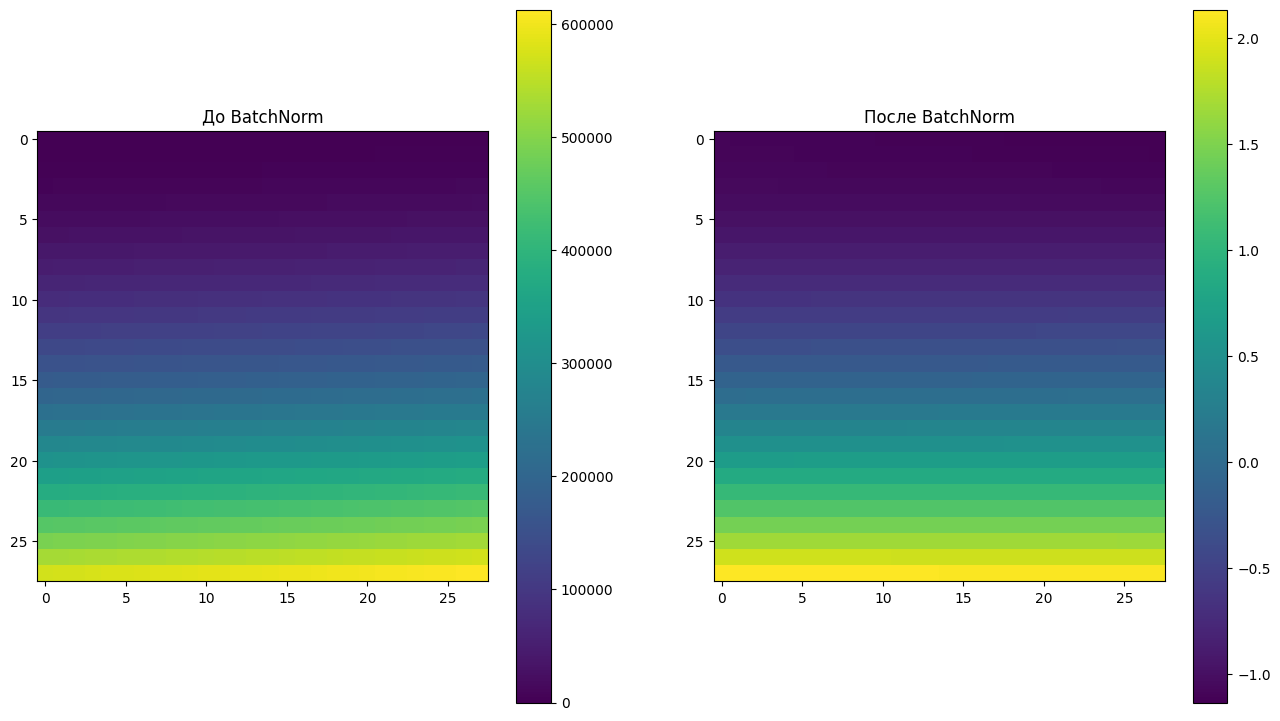

In [4]:
from torch.testing import assert_close

before_bn = torch.arange(28 * 28, dtype=torch.float32).reshape((28, 28)) ** 2
# По умолчанию BatchNorm считает градиенты (т.к. учит gamma и beta), отключим это в рамках демо
with torch.no_grad():
    after_bn = batch_norm_layer(before_bn)

hand_made_bn = before_bn - before_bn.mean(0, keepdim=True)
hand_made_bn = hand_made_bn / before_bn.std(0, keepdim=True, unbiased=False)
# Проверим, что BatchNorm делает то, что писали выше
assert_close(hand_made_bn, after_bn, msg="Не сошлись значения")

# И нарисуем, что получилось
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
plt.colorbar(ax[0].imshow(before_bn.numpy()), ax=ax[0])
plt.colorbar(ax[1].imshow(after_bn.numpy()), ax=ax[1])
ax[0].set_title("До BatchNorm")
ax[1].set_title("После BatchNorm");